# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

Load libraries for analysis and visualization:

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import Dataset, ItemListCollection
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

In [4]:
from lkdemo.datasets import split_fraction

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [5]:
dataset = "ml-100k"

In [6]:
# Parameters
dataset = "ml-latest-small"


In [7]:
output_root = Path("runs")

In [8]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [9]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = ItemListCollection.load_parquet(file)
        recs.add_from(rec, model=fld.name.split("-")[-1])

In [10]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [11]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = ItemListCollection.load_parquet(file)
        preds.add_from(pred, model=fld.name.split("-")[-1])

We need to load the test data so that we have the ground truths for computing accuracy.

In [12]:
data = Dataset.load(f"data/{dataset}")
split = split_fraction(data, 0.2)
test = split.test

And identify users in the training set, so we only report metrics over them.

In [13]:
train_users = split.train.user_stats()
train_users = train_users[train_users['rating_count'] > 0]

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [14]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean    median       std
model                                        
ALS   NDCG       0.143585  0.123258  0.109129
      RBP        0.196283  0.191755  0.174216
      RecipRank  0.572264  1.000000  0.451754
Bias  NDCG       0.144237  0.123258  0.112597
      RBP        0.194368  0.185718  0.176979
      RecipRank  0.569998  1.000000  0.459706
IALS  NDCG       0.036128  0.011909  0.087273
      RBP        0.026444  0.000703  0.084116
      RecipRank  0.057071  0.029412  0.123974
IIE   NDCG       0.003376  0.000000  0.012898
      RBP        0.002943  0.000000  0.016685
      RecipRank  0.008005  0.000000  0.038480
III   NDCG       0.025775  0.000000  0.080206
      RBP        0.025322  0.000000  0.093465
      RecipRank  0.053646  0.000000  0.181649
Pop   NDCG       0.217502  0.197962  0.154321
      RBP        0.365221  0.350361  0.287828
      RecipRank  0.637057  1.000000  0.420176
UUE   NDCG       0.000188  0.000000  0.001452
      RBP        0.000281  0.000000  0.002754
      RecipRank  0.001129  0.000000  0.009192

We can reshape the list metrics and plot them:

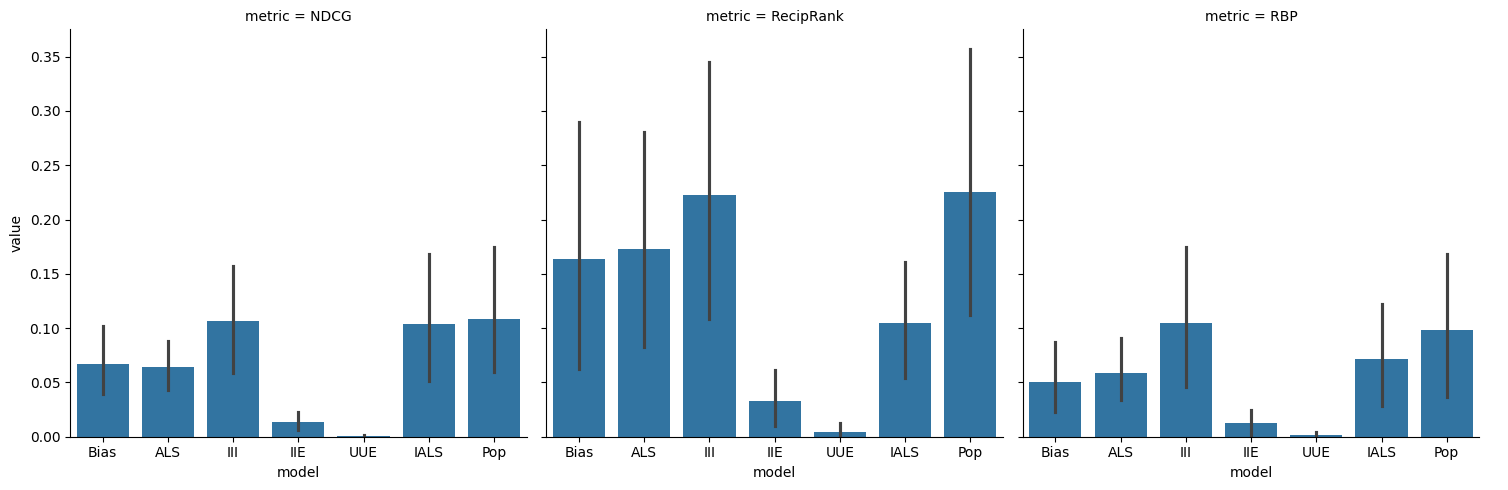

In [15]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
metrics = metrics[metrics['user_id'].isin(train_users.index)]
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [16]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.961093,0.898315,0.343152
Bias,RMSE,0.965678,0.899920,0.346167
IIE,RMSE,0.996960,0.942495,0.358581
UUE,RMSE,1.005463,0.942495,0.356630


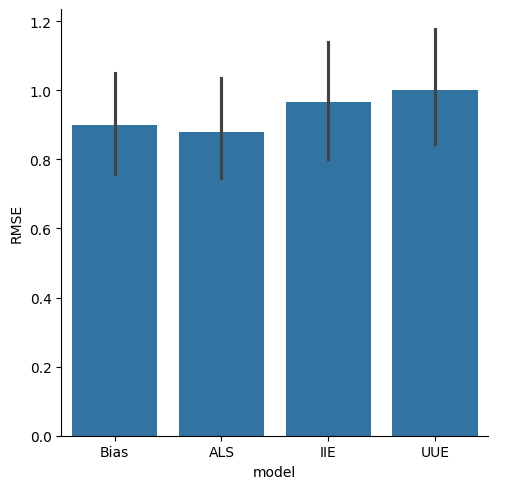

In [17]:
pred_metrics = pred_results.list_metrics().reset_index()
pred_metrics = pred_metrics[pred_metrics['user_id'].isin(train_users.index)]
sns.catplot(pred_metrics, x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [18]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.143585,0.196283,0.572264
Bias,0.144237,0.194368,0.569998
IALS,0.036128,0.026444,0.057071
IIE,0.003376,0.002943,0.008005
III,0.025775,0.025322,0.053646
Pop,0.217502,0.365221,0.637057
UUE,0.000188,0.000281,0.001129


In [19]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')